In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import far_ho as far
import far_ho.examples as far_ex

tf.logging.set_verbosity(tf.logging.ERROR)

No module named 'pysftp'
Data folder is /media/luca/DATA/DATASETS
Experiment save directory is  /media/luca/DATA/EXPERIMENTS


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [3]:
try:
    sess.close()
except: pass
rnd = np.random.RandomState(1)
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Far-HO Demo, AutoML 2018, ICML workshop
### Far-HO: a Bilevel Programming Package for Hyperparameter Optimization and meta-learning 

[Link to the workshop paper](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxhdXRvbWwyMDE4aWNtbHxneDoyN2I3YmIxNTkyMjMwYjRm)

### Data 

In [4]:
def to_one_hot_enc(seq, dimension=None):
    da_max = dimension or int(np.max(seq)) + 1
    _tmp = np.zeros((len(seq), da_max))
    _tmp[range(len(_tmp)), np.array(seq, dtype=int)] = 1
    return _tmp

def flip(targets, p):
    tgs = np.argmax(targets, axis=1)
    nfl = int(len(targets)*p)
    tgs[:nfl] = (tgs[:nfl] + rnd.randint(1, 9, size=(nfl,))) % 10
    return to_one_hot_enc(tgs)

def get_data(p, small=True):
    # load a small portion of mnist data
    if small: part = (.02, .002,)
    else: part = (.5, .1)
    datasets = far_ex.mnist(data_root_folder=os.path.join(os.getcwd(), 'MNIST_DATA'), partitions=part)
    if p: 
        datasets.train._target = flip(datasets.train.target, p)
    return datasets

### Models

In [5]:
def g_logits(x,y, name='model'):
    with tf.variable_scope(name):
        h1 = layers.fully_connected(x, 300)
        logits = layers.fully_connected(h1, int(y.shape[1]))
    return logits

def g_logits_d(x,y, name='model'):
    return far_ex.fixed_init_ffnn(x, dims=(x.shape[1], 400, 400, 400, y.shape[1]), name=name)

### Find automatically the weights of each training example  (DATA HYPER-CLEANER)
NOISE ON LABELS of the examples  

In [6]:
x = tf.placeholder(tf.float32, shape=(None, 28**2), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
logits = g_logits(x, y)
P = 1/3
train_set, validation_set, test_set = get_data(p=P)

Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/autoMLDemos/MNIST_DATA/mnist/train-images-idx3-ubyte.gz
Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/autoMLDemos/MNIST_DATA/mnist/train-labels-idx1-ubyte.gz
Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/autoMLDemos/MNIST_DATA/mnist/t10k-images-idx3-ubyte.gz
Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/autoMLDemos/MNIST_DATA/mnist/t10k-labels-idx1-ubyte.gz
datasets.redivide_data:, computed partitions numbers - [0, 1400, 1540, 70000] len all 70000 DONE


In [7]:
lambdas = far.get_hyperparameter('lambdas', tf.zeros(train_set.num_examples))
lr = far.get_hyperparameter('lr', initializer=0.02, constraint=lambda t: tf.maximum(tf.minimum(t, 1.), 1.e-5))

ce = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
example_weights = tf.sigmoid(lambdas)
L = tf.reduce_mean(example_weights*ce)
E = tf.reduce_mean(ce)

In [8]:
inner_optimizer = far.GradientDescentOptimizer(lr)
outer_optimizer = tf.train.AdamOptimizer(0.02)
hyper_step = far.HyperOptimizer().minimize(E, outer_optimizer, L, inner_optimizer)

T = 300  # Number of inner iterations
train_set_supplier = train_set.create_supplier(x, y)
validation_set_supplier = validation_set.create_supplier(x, y)

In [9]:
tf.global_variables_initializer().run()

In [10]:
def show_img(ax, data, label, other_info=""):
    ax.imshow(np.reshape(data, (28, 28)), cmap='gray')
    ax.grid()
    ax.set_title('label {} {:.3}'.format(np.argmax(label), other_info))
    ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False)

def make_plots1():
    clear_output()
    print('inner:', L.eval(train_set_supplier()))
    print('outer:', E.eval(validation_set_supplier()))
    print('learning rate', lr.eval())
    print('norm of examples weights', tf.norm(lambdas).eval())
    print('-'*50)

    fig, ax = plt.subplots(ncols=5, figsize=(16, 3))

    img_ax = 0
    for img_idx in range(4):
        _id = rnd.randint(0, 1400)
        show_img(ax[img_ax], train_set.data[_id], train_set.target[_id], example_weights.eval()[_id])
        img_ax+=1
#         plt.show()
    evv = example_weights.eval()
    
    plt.sca(ax[-1])
    xx = [0, 1]
    flipped =  evv[:int(P*len(evv))]
    clean = evv[int(P*len(evv)):]
    ax[-1].set_title('Weights of examples')
    plt.xticks([0, 1], ['Flipped', 'Clean'])
    ax[-1].errorbar([0, 1], [np.mean(flipped), np.mean(clean)], yerr=[np.std(flipped), np.std(clean)], fmt='o')
    ax[-1].set_xlim((-0.5, 1.5))
    ax[-1].yaxis.tick_right()


    plt.show()
    

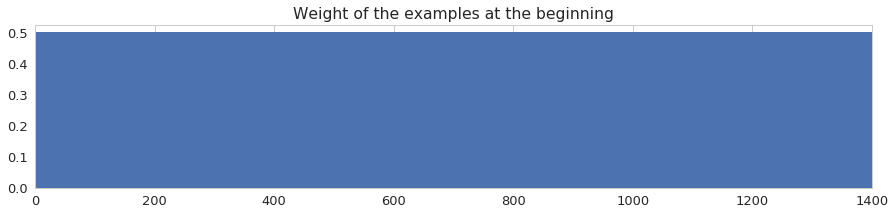

In [11]:
plt.figure(figsize=(15, 3))
plt.bar(list(range(train_set.num_examples)), example_weights.eval(), width=1.);
plt.xlim(0,1400)
plt.title('Weight of the examples at the beginning');

inner: 0.6678092
outer: 0.9994712
learning rate 0.1317361
norm of examples weights 5.5008063
--------------------------------------------------


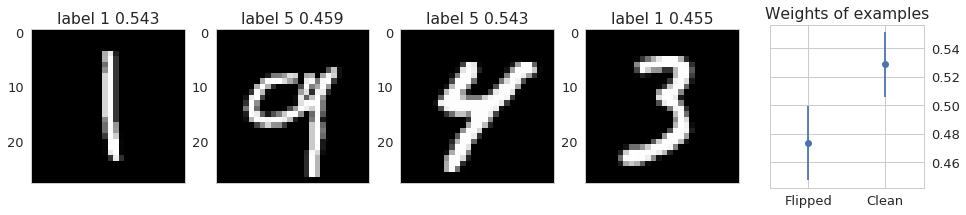

In [12]:
# examples 
n_hyper_iterations = 10
for hyt in range(n_hyper_iterations):
    hyper_step(T,
               inner_objective_feed_dicts=train_set_supplier,
               outer_objective_feed_dicts=validation_set_supplier)
    if hyt % 2 ==0:
        make_plots1()

(0, 1400)

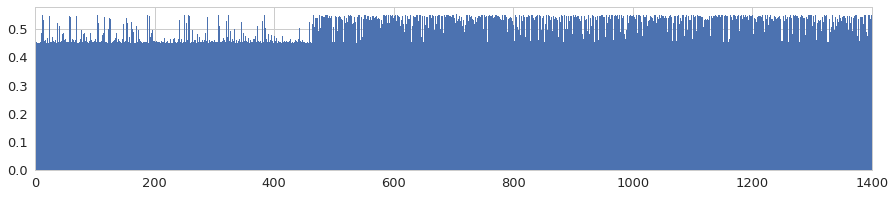

In [13]:
plt.figure(figsize=(15, 3))
plt.bar(list(range(train_set.num_examples)), example_weights.eval(), width=1.);
plt.xlim(0,1400)


### Optimize few hyperparameters  with `ForwardHG`


































In [14]:
try:
    sess.close()
except: pass
tf.reset_default_graph()
sess = tf.InteractiveSession()


In [15]:
x = tf.placeholder(tf.float32, shape=(None, 28**2), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
logits = g_logits_d(x, y, name='mod3')
P = None
train_set, validation_set, test_set = get_data(p=P, small=False)

Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/autoMLDemos/MNIST_DATA/mnist/train-images-idx3-ubyte.gz
Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/autoMLDemos/MNIST_DATA/mnist/train-labels-idx1-ubyte.gz
Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/autoMLDemos/MNIST_DATA/mnist/t10k-images-idx3-ubyte.gz
Extracting /media/luca/DATA/Progs/FAR-HO/far_ho/examples/autoMLDemos/MNIST_DATA/mnist/t10k-labels-idx1-ubyte.gz
datasets.redivide_data:, computed partitions numbers - [0, 35000, 42000, 70000] len all 70000 DONE


In [16]:
# lambdas = far.get_hyperparameter('lambdas', tf.zeros(train_set.num_examples))
lr = far.get_hyperparameter('lr', initializer=0.02, constraint=lambda t: tf.maximum(tf.minimum(t, .1), 1.e-5))
mu = far.get_hyperparameter('mu', initializer=0.9, constraint=lambda t: tf.maximum(tf.minimum(t, .99), 1.e-5))
rho = far.get_hyperparameter('rho', initializer=0.00001, constraint=lambda t: tf.maximum(tf.minimum(t, 0.01), 0.))


ce = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
L = tf.reduce_mean(ce) + rho*tf.add_n([tf.reduce_sum(w**2) for w in tf.trainable_variables()])
E = tf.reduce_mean(ce)

In [17]:
inner_optimizer = far.MomentumOptimizer(lr, mu)
outer_optimizer = tf.train.AdamOptimizer(1.e-4)
hyper_step = far.HyperOptimizer(far.ForwardHG()).minimize(E, outer_optimizer, L, inner_optimizer)

train_set_supplier = train_set.create_supplier(x, y, batch_size=256)  # stochastic GD
validation_set_supplier = validation_set.create_supplier(x, y)

In [18]:
def make_plots2(his):
    clear_output()
    print('inner:', L.eval(train_set_supplier()))
    print('outer:', E.eval(validation_set_supplier()))
    print('learning rate', lr.eval(), 'momentum', mu.eval(), 'l2 coefficient', rho.eval())
    print('-'*50)
    
    fig, ax = plt.subplots(ncols=4, figsize=(15, 3))
    ax[0].set_title('Learning rate')
    ax[0].plot([e[0] for e in his])
    
    ax[1].set_title('Momentum factor')
    ax[1].plot([e[1] for e in his]) 
    
    ax[2].set_title('L2 regulariz.')
    ax[2].plot([e[2] for e in his])
    
    ax[3].set_title('Tr. and val. errors')
    ax[3].plot([e[3] for e in his])
    ax[3].plot([e[4] for e in his])  
    
    
    plt.show()

In [19]:
T = 500
his_params = []
n_hyper_iterations = 10

In [20]:
tf.global_variables_initializer().run()

inner: 0.1708527
outer: 0.156994
learning rate 0.020994974 momentum 0.9009989 l2 coefficient 0.0
--------------------------------------------------


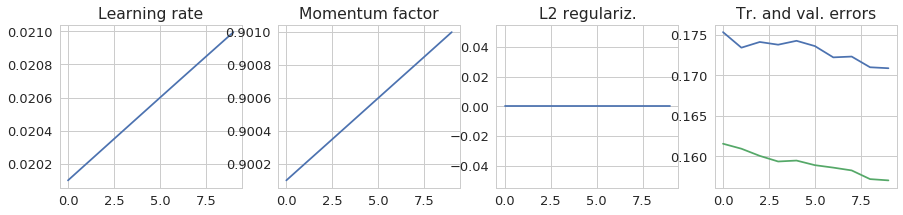

In [21]:
n_hyper_iterations = 10
for hyt in range(n_hyper_iterations):
    hyper_step(T,
               inner_objective_feed_dicts=train_set_supplier,
               outer_objective_feed_dicts=validation_set_supplier)
    res = sess.run(far.hyperparameters()) + [L.eval(train_set_supplier()), 
                                             E.eval(validation_set_supplier())]
    his_params.append(res)
    make_plots2(his_params)

### Too slow? Update the hyperparameters online!
### [RTHO](http://proceedings.mlr.press/v70/franceschi17a): REAL-TIME HYPERPARAMETER OPTIMIZATION 

In [22]:
hyper_batch_size = 100  # Number of inner iterations
T = 5000
his_params = []


In [23]:
tf.global_variables_initializer().run()

inner: 1.2447232
outer: 0.10679205
learning rate 0.02119322 momentum 0.90058875 l2 coefficient 0.0008570271
--------------------------------------------------


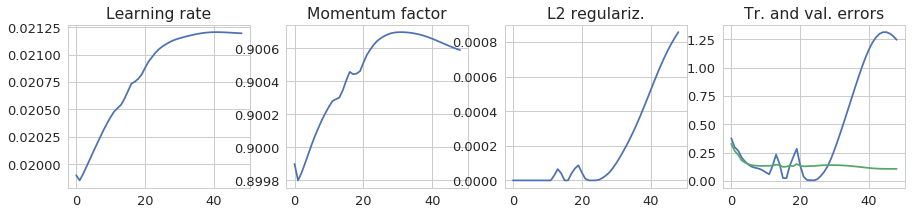

In [24]:
for hyt in range(T//hyper_batch_size):
    hyper_step(hyper_batch_size,
               inner_objective_feed_dicts=train_set_supplier,
               outer_objective_feed_dicts=validation_set_supplier, online=True)
    res = sess.run(far.hyperparameters()) + [L.eval(train_set_supplier()), 
                                             E.eval(validation_set_supplier())]
    his_params.append(res)
    if hyt % 2 ==0:
        make_plots2(his_params)

### COMING SOON: FABIAN PEDREGOSA'S [HOAG](http://proceedings.mlr.press/v48/pedregosa16)